# Dự đoán giá vé máy bay sử dụng LightGBM

Notebook này tập trung vào việc huấn luyện mô hình LightGBM để dự đoán giá vé máy bay dựa trên dữ liệu đã được làm sạch ở notebook đầu tiên. Chúng ta sẽ có quy trình xây dựng, tinh chỉnh và đánh giá mô hình một cách hệ thống, phân tích hiệu suất của mô hình trên các chỉ số khác nhau và các phân khúc giá.

## 1. Import các thư viện cần thiết

Trước hết, hãy import tất cả các thư viện cần thiết cho việc mô hình hóa.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tabulate import tabulate
import warnings
warnings.filterwarnings("ignore")

# Xử lý và phân tích dữ liệu
import numpy as np
import pandas as pd

# Mô hình hóa
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Trực quan hóa
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Khác
import os
import warnings
warnings.filterwarnings('ignore')

# Đặt giá trị ngẫu nhiên để kết quả có thể tái tạo
np.random.seed(42)

## 2. Tải dữ liệu

Tải dữ liệu đã được tiền xử lý từ thư mục clean_data.

In [2]:
# Load the dataset train, val, test from ../clean_data
train_df = pd.read_csv('../clean_data/train_cleaned.csv')
val_df = pd.read_csv('../clean_data/val_cleaned.csv')
test_df = pd.read_csv('../clean_data/test_cleaned.csv')

print(f"Kích thước dữ liệu huấn luyện: {train_df.shape}")
print(f"Kích thước dữ liệu kiểm định: {val_df.shape}")
print(f"Kích thước dữ liệu kiểm tra: {test_df.shape}")

Kích thước dữ liệu huấn luyện: (8946, 55)
Kích thước dữ liệu kiểm định: (1917, 55)
Kích thước dữ liệu kiểm tra: (1918, 55)


In [3]:
train_df.head()

,Duration,Date,Total_Stops,SClass,Price,Departure_Hour,Departure_Min,Arrival_Hour,Arrival_Min,Airline_Bamboo Airways,...,Destination_TBB,Destination_THD,Destination_UIH,Destination_VCA,Destination_VCL,Destination_VCS,Destination_VDH,Destination_VDO,Destination_VII,Destination_VKG
0,-0.171875,18,0,0,2654000,19,50,21,5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.796875,18,1,0,8983000,9,15,15,40,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.140625,17,1,1,1735000,9,50,18,5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.156250,17,0,0,1859000,9,50,11,10,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.171875,15,0,1,2536000,12,5,13,20,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Xác định biến mục tiêu
target = 'Price'

# Tách biến đặc trưng và biến mục tiêu
X_train = train_df.drop(target, axis=1)
y_train = train_df[target]

X_val = val_df.drop(target, axis=1) 
y_val = val_df[target]

X_test = test_df.drop(target, axis=1)
y_test = test_df[target]

# Kiểm tra tên các đặc trưng
print(f"Các đặc trưng: {X_train.columns.tolist()}")
print(f"Số lượng đặc trưng: {len(X_train.columns)}")

Các đặc trưng: ['Duration', 'Date', 'Total_Stops', 'SClass', 'Departure_Hour', 'Departure_Min', 'Arrival_Hour', 'Arrival_Min', 'Airline_Bamboo Airways', 'Airline_VietJet Air', 'Airline_Vietnam Airlines', 'Airline_Vietravel Airlines', 'Departure_BMV', 'Departure_CAH', 'Departure_CXR', 'Departure_DAD', 'Departure_DLI', 'Departure_HAN', 'Departure_HPH', 'Departure_HUI', 'Departure_PQC', 'Departure_PXU', 'Departure_SGN', 'Departure_TBB', 'Departure_THD', 'Departure_UIH', 'Departure_VCA', 'Departure_VCL', 'Departure_VCS', 'Departure_VDH', 'Departure_VDO', 'Departure_VII', 'Departure_VKG', 'Destination_BMV', 'Destination_CAH', 'Destination_CXR', 'Destination_DAD', 'Destination_DLI', 'Destination_HAN', 'Destination_HPH', 'Destination_HUI', 'Destination_PQC', 'Destination_PXU', 'Destination_SGN', 'Destination_TBB', 'Destination_THD', 'Destination_UIH', 'Destination_VCA', 'Destination_VCL', 'Destination_VCS', 'Destination_VDH', 'Destination_VDO', 'Destination_VII', 'Destination_VKG']
Số lượng đ

## 3. Tìm hiểu về LightGBM

### LightGBM là gì?

LightGBM (Light Gradient Boosting Machine) là một framework gradient boosting được phát triển bởi Microsoft sử dụng các thuật toán học máy dựa trên cây. Nó được thiết kế để hiệu quả, nhanh chóng và có khả năng xử lý dữ liệu quy mô lớn với lượng bộ nhớ sử dụng thấp hơn các cách triển khai gradient boosting khác.

### Nguyên lý chính của LightGBM

#### 1. Chiến lược tăng trưởng cây theo lá (Leaf-wise Tree Growth)

Khác với các thuật toán khác sử dụng tăng trưởng theo mức (level-wise/breadth-first), LightGBM tăng trưởng cây theo lá. Nó chọn lá có delta loss lớn nhất để phát triển, điều này có thể dẫn đến cây sâu hơn nhưng độ chính xác tiềm năng cao hơn. Phương pháp này có thể giảm loss hiệu quả hơn so với tăng trưởng theo mức khi xử lý cùng số lượng chia cắt.

![Leaf-wise vs Level-wise](https://lightgbm.readthedocs.io/en/latest/_images/leaf-wise.png)

#### 2. Lấy mẫu một phía dựa trên Gradient (GOSS)

LightGBM sử dụng GOSS để xử lý hiệu quả các tập dữ liệu lớn. Nó giữ lại các mẫu có gradient lớn (góp phần nhiều hơn vào information gain) và lấy mẫu ngẫu nhiên từ các mẫu có gradient nhỏ. Điều này tập trung hơn vào các mẫu chưa được huấn luyện tốt trong khi vẫn duy trì độ chính xác.

#### 3. Gói đặc trưng độc quyền (EFB)

Với dữ liệu thưa có chiều cao, LightGBM gói các đặc trưng loại trừ lẫn nhau (những đặc trưng hiếm khi nhận giá trị khác 0 đồng thời) để giảm chiều mà không mất thông tin.

#### 4. Thuật toán dựa trên biểu đồ phân phối (Histogram)

LightGBM chia nhỏ giá trị đặc trưng liên tục thành các bin rời rạc, giúp tăng tốc độ huấn luyện và giảm sử dụng bộ nhớ.

### Tham số chính trong LightGBM

#### Tham số cấu trúc cây

- **num_leaves**: Số lượng lá tối đa trong một cây. Điều khiển độ phức tạp của cây. Giá trị cao hơn tăng độ chính xác nhưng có thể dẫn đến overfitting.
- **max_depth**: Độ sâu tối đa của cây. Dùng để giới hạn độ sâu của cây và kiểm soát overfitting.
- **min_data_in_leaf**: Số lượng dữ liệu tối thiểu trong một lá. Giá trị cao hơn có thể giúp ngăn chặn overfitting.

#### Tham số điều khiển học

- **learning_rate**: Độ lớn bước của mỗi vòng boosting. Giá trị thấp hơn yêu cầu nhiều vòng boosting hơn nhưng có thể dẫn đến hiệu suất tốt hơn.
- **n_estimators**: Số lượng vòng lặp boosting (số cây).
- **early_stopping**: Huấn luyện dừng lại nếu metrics không cải thiện trong một số vòng nhất định.

#### Tham số lấy mẫu

- **subsample**: Tỷ lệ mẫu được sử dụng để huấn luyện.
- **colsample_bytree**: Tỷ lệ đặc trưng được sử dụng cho mỗi cây.

### Hàm mất mát - MSE (Mean Squared Error)

Với các bài toán hồi quy như dự đoán giá vé máy bay, LightGBM thường sử dụng Mean Squared Error (MSE) làm hàm mất mát mặc định. Công thức cho MSE là:

$$MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$

Trong đó:
- $n$ là số lượng mẫu
- $y_i$ là giá trị thực tế
- $\hat{y}_i$ là giá trị dự đoán

MSE phạt lỗi lớn mạnh mẽ do thao tác bình phương, làm cho nó đặc biệt phù hợp cho các trường hợp mà outlier cần được chú ý đặc biệt.

## 4. Định nghĩa các hàm tiện ích

### Hàm mất mát (Loss Functions) trong mô hình LightGBM

Trong notebook này, chúng ta sử dụng một số hàm mất mát (loss functions) khác nhau để huấn luyện và đánh giá mô hình LightGBM:

1. **Trong quá trình huấn luyện mô hình LightGBM**: 
   - Mặc định, LightGBM sử dụng **Mean Squared Error (MSE)** làm hàm mất mát cho bài toán hồi quy.
   - Công thức: $$MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$
   - MSE phạt nặng các lỗi lớn do phép bình phương, phù hợp cho bài toán dự đoán giá vé máy bay nơi các dự đoán quá cao hoặc quá thấp đều không mong muốn.

2. **Trong quá trình đánh giá và tìm kiếm tham số tối ưu**:
   - Chúng ta sử dụng `neg_mean_squared_error` trong GridSearchCV.
   - Scikit-learn yêu cầu các metrics phải là "càng cao càng tốt", nên sử dụng giá trị âm của MSE.
   - Các metrics khác sử dụng trong cross-validation: R², MAE (Mean Absolute Error).

3. **Các metrics để đánh giá hiệu suất**:
   - **R²** (R-squared): Chỉ số xác định, cho biết mức độ biến thiên của biến mục tiêu được giải thích bởi mô hình. Giá trị từ 0-1, càng gần 1 càng tốt.
   - **MAE** (Mean Absolute Error): Trung bình của sai số tuyệt đối giữa giá trị dự đoán và thực tế.
   - **MSE** (Mean Squared Error): Trung bình của bình phương sai số.
   - **RMSE** (Root Mean Squared Error): Căn bậc hai của MSE, cho kết quả trong cùng đơn vị với biến mục tiêu.

Việc sử dụng các hàm mất mát và metrics khác nhau giúp đánh giá mô hình từ nhiều góc độ, đảm bảo mô hình không chỉ tối ưu hóa một mặt mà còn cân bằng giữa các yếu tố khác nhau của bài toán dự đoán giá vé máy bay.

In [5]:
def feature_importance(ml_model, x_train=X_train, y_train=y_train): 
    print('Model: {}'.format(ml_model))
    model = ml_model.fit(x_train, y_train)
    plt.figure(figsize=(15,10))
    feat_importances = pd.Series(model.feature_importances_, index=x_train.columns).sort_values(ascending = True)
    feat_importances.plot(kind='barh')
    plt.show()

In [6]:
def predict(ml_model, X_train, X_val):
    print('Model: {}'.format(ml_model))
    table = []
    headers = ['Metrics', 'Values']
    
    model = ml_model.fit(X_train, y_train)
    
    training_score = model.score(X_train, y_train)
    val_score = model.score(X_val, y_val)
    table.append(['Training score', training_score])
    table.append(['Validation score', val_score])

    predictions = model.predict(X_val)
    
    MAE = mean_absolute_error(y_val, predictions)
    MSE = mean_squared_error(y_val, predictions)
    RMSE = np.sqrt(MSE)
    
    table.append(['MAE', MAE]) 
    table.append(['MSE', MSE]) 
    table.append(['RMSE', RMSE])
    
    print(tabulate(table, headers=headers, tablefmt='fancy_grid', numalign='right', floatfmt=".2f"))
    
    return predictions, training_score, val_score, MAE, MSE, RMSE

In [7]:
def plot(predictions):
    sns.distplot(y_test-predictions)
    
    fig1, ax = plt.subplots(1, 1, figsize=(20, 5))

    ax.plot([i for i in range(250)], y_test[0:250],  color='blue')
    ax.plot([i for i in range(250)], predictions[0:250], color='orange')

    ax.set_ylabel("Price (VND)")
    ax.legend(['true price', 'predict price'])

    fig1.show()
    
    fig2, ax = plt.subplots(1, 1, figsize=(20, 5))

    ax.scatter([i for i in range(250)], y_test[0:250],  color='blue', linewidths=4)
    ax.scatter([i for i in range(250)], predictions[0:250], color='orange', linewidths=3)
    
    ax.set_ylabel("Price (VND)")
    ax.legend(['true price', 'predict price'])
    
    fig2.show()

In [8]:
def plot_val(predictions):
    # Use the validation data since predict() uses X_val
    sns.distplot(y_val-predictions)
    
    # Ensure we're only plotting the available data
    n_samples = min(250, len(y_val), len(predictions))
    
    fig1, ax = plt.subplots(1, 1, figsize=(20, 5))

    ax.plot([i for i in range(n_samples)], y_val[0:n_samples],  color='blue')
    ax.plot([i for i in range(n_samples)], predictions[0:n_samples], color='orange')

    ax.set_ylabel("Price (VND)")
    ax.legend(['true price', 'predict price'])

    fig1.show()
    
    fig2, ax = plt.subplots(1, 1, figsize=(20, 5))

    ax.scatter([i for i in range(n_samples)], y_val[0:n_samples],  color='blue', linewidths=4)
    ax.scatter([i for i in range(n_samples)], predictions[0:n_samples], color='orange', linewidths=3)
    
    ax.set_ylabel("Price (VND)")
    ax.legend(['true price', 'predict price'])
    
    fig2.show()

## 5. Huấn luyện mô hình LightGBM

Model: LGBMRegressor(random_state=42)
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8946, number of used features: 52
[LightGBM] [Info] Start training from score 3431747.048960


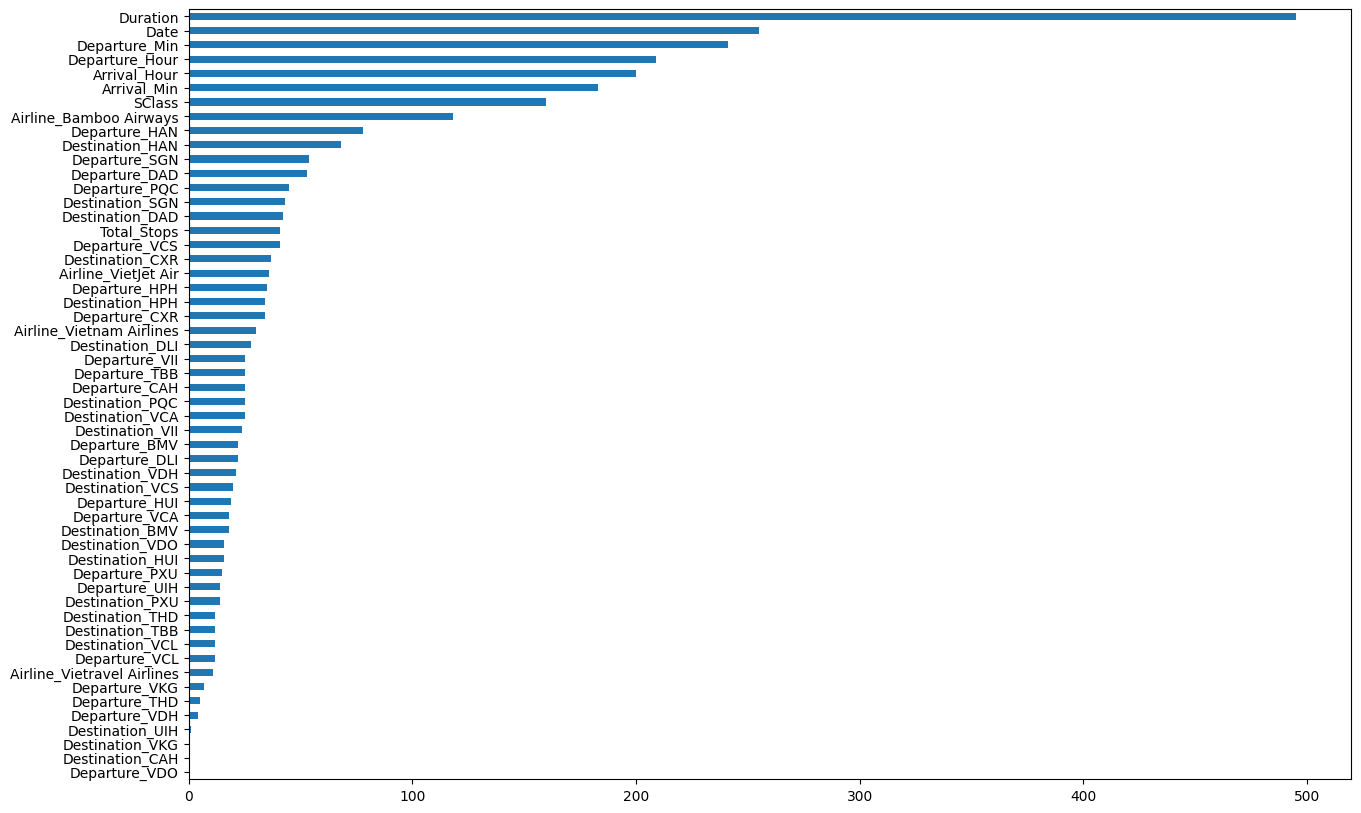

In [9]:
lightgb = lgb.LGBMRegressor(random_state=42)
feature_importance(lightgb)

#### Lưu các đặc trưng quan trọng nhất

In [10]:
importance = pd.Series(lightgb.feature_importances_, index=X_train.columns).sort_values(ascending = False)
importance_df = pd.DataFrame(importance)
importance_df = importance_df.reset_index()
importance_df.columns = ['Feature', 'Importance']
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df = importance_df.head(7)
importance_df.to_csv('../models/feature_importance.csv', index=False)
importance_df = pd.read_csv('../models/feature_importance.csv') 
importance_df

,Feature,Importance
0,Duration,495
1,Date,255
2,Departure_Min,241
3,Departure_Hour,209
4,Arrival_Hour,200
5,Arrival_Min,183
6,SClass,160


#### 1. WITHOUT FEATURE SELECTIION

Model: LGBMRegressor(random_state=42)
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8946, number of used features: 52
[LightGBM] [Info] Start training from score 3431747.048960
╒══════════════════╤═════════════════╕
│ Metrics          │          Values │
╞══════════════════╪═════════════════╡
│ Training score   │            0.94 │
├──────────────────┼─────────────────┤
│ Validation score │            0.93 │
├──────────────────┼─────────────────┤
│ MAE              │       409131.63 │
├──────────────────┼─────────────────┤
│ MSE              │ 346888188029.77 │
├──────────────────┼─────────────────┤
│ RMSE             │       588972.15 │
╘═══

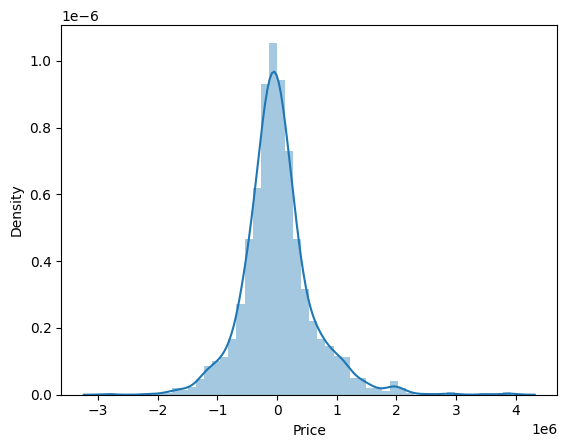

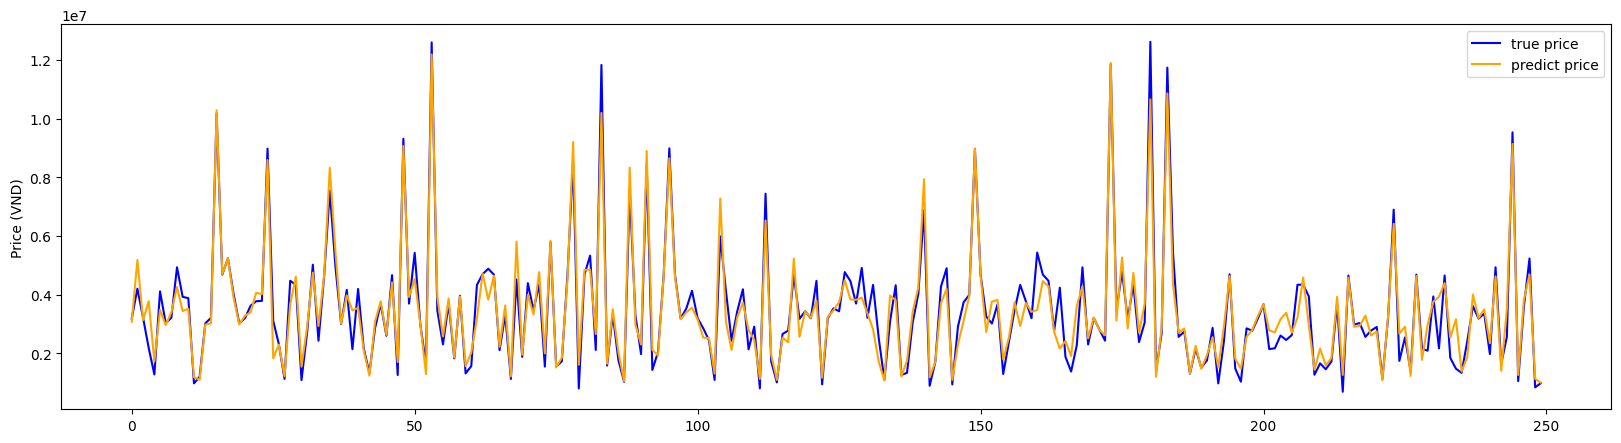

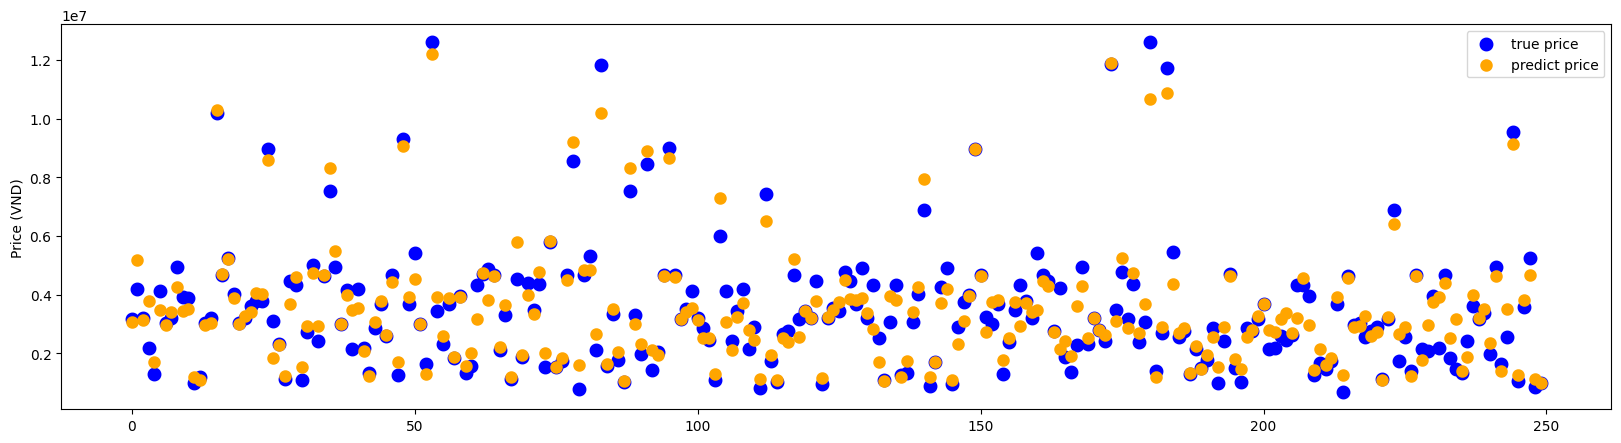

In [11]:
predictions_lgb, training_score_lgb, val_score_lgb, MAE_lgb, MSE_lgb, RMSE_lgb = predict(lightgb, X_train, X_val)
plot_val(predictions_lgb)

#### 2. WITH FEATURE SELECTIION

In [12]:
X_train_lgb = X_train[importance_df['Feature'].tolist()]
X_val_lgb = X_val[importance_df['Feature'].tolist()]
X_train_lgb.head(10)

,Duration,Date,Departure_Min,Departure_Hour,Arrival_Hour,Arrival_Min,SClass
0,-0.171875,18,50,19,21,5,0
1,0.796875,18,15,9,15,40,0
2,1.140625,17,50,9,18,5,1
3,-0.156250,17,50,9,11,10,0
4,-0.171875,15,5,12,13,20,1
5,-0.093750,21,35,12,14,15,1
6,-0.125000,16,5,16,17,35,1
7,1.343750,17,10,9,18,30,1
8,0.984375,17,30,15,22,55,1
9,-0.187500,20,5,8,9,15,2


Model: LGBMRegressor(random_state=42)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 234
[LightGBM] [Info] Number of data points in the train set: 8946, number of used features: 7
[LightGBM] [Info] Start training from score 3431747.048960
╒══════════════════╤═════════════════╕
│ Metrics          │          Values │
╞══════════════════╪═════════════════╡
│ Training score   │            0.89 │
├──────────────────┼─────────────────┤
│ Validation score │            0.87 │
├──────────────────┼─────────────────┤
│ MAE              │       567611.56 │
├──────────────────┼─────────────────┤
│ MSE              │ 602402286800.55 │
├──────────────────┼─────────────────┤
│ RMSE             │       776145.79 │
╘══════════════════╧═════════════════╛


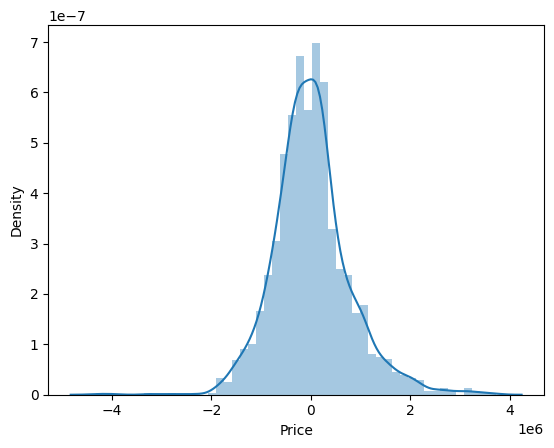

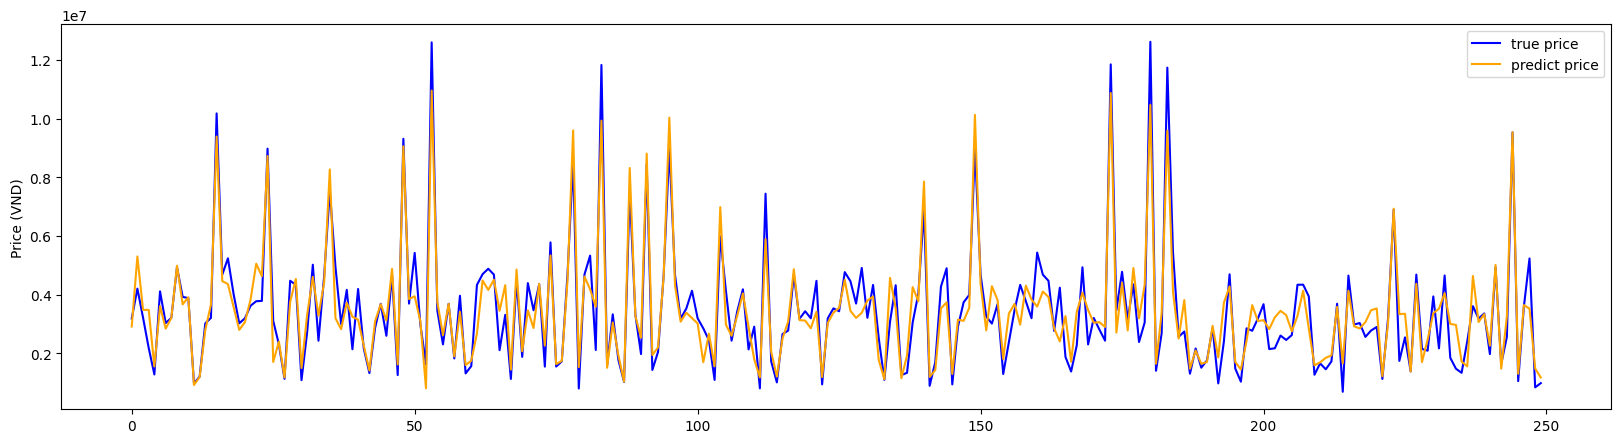

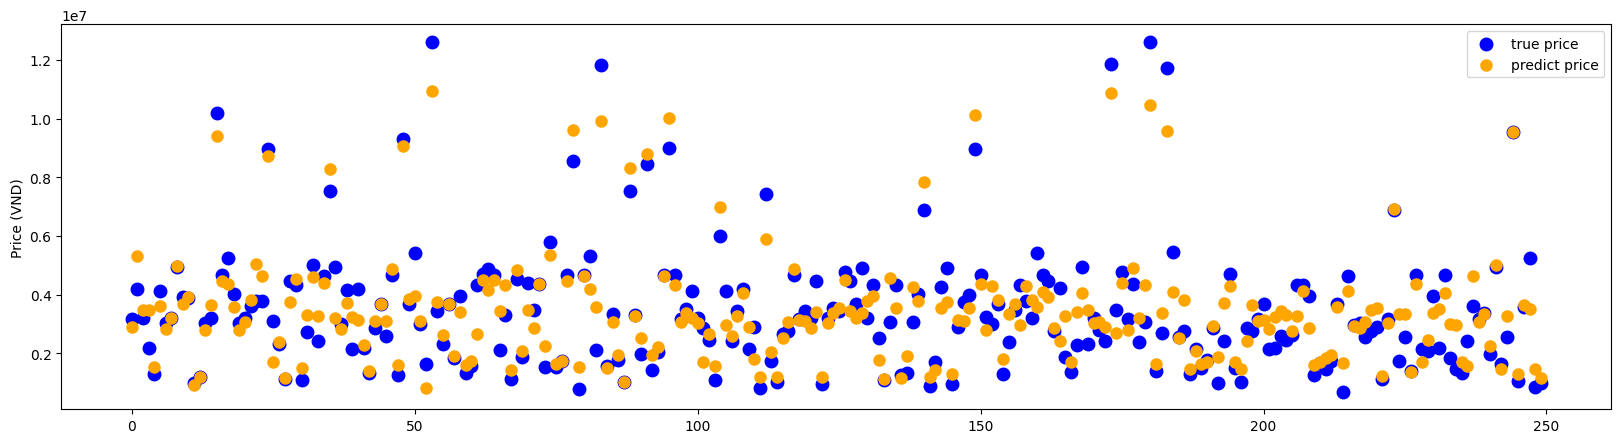

In [13]:
predictions_lgb_fs, training_score_lgb_fs, val_score_lgb_fs ,MAE_lgb_fs, MSE_lgb_fs, RMSE_lgb_fs = predict(lightgb, X_train_lgb, X_val_lgb)
plot_val(predictions_lgb_fs)

#### So sánh giữa các mô hình LightGBM với và không có feature selection. Sử dụng các chỉ số như R², MAE, MSE, RMSE để đánh giá hiệu suất của mô hình.

In [14]:
print('Model: {}'.format(lightgb))
table_lgb = []
table_lgb.append(['', 'Without Feature Selection', 'With Feature Selection'])
table_lgb.append(['Training score', training_score_lgb, training_score_lgb_fs])
table_lgb.append(['Testing score', val_score_lgb, val_score_lgb_fs])
table_lgb.append(['MAE', MAE_lgb, MAE_lgb_fs])
table_lgb.append(['MSE', MSE_lgb, MSE_lgb_fs])
table_lgb.append(['RMSE', RMSE_lgb, RMSE_lgb_fs])
print(tabulate(table_lgb, headers='firstrow', tablefmt='fancy_grid', numalign='right', floatfmt=".2f"))

Model: LGBMRegressor(random_state=42)
╒════════════════╤═════════════════════════════╤══════════════════════════╕
│                │   Without Feature Selection │   With Feature Selection │
╞════════════════╪═════════════════════════════╪══════════════════════════╡
│ Training score │                        0.94 │                     0.89 │
├────────────────┼─────────────────────────────┼──────────────────────────┤
│ Testing score  │                        0.93 │                     0.87 │
├────────────────┼─────────────────────────────┼──────────────────────────┤
│ MAE            │                   409131.63 │                567611.56 │
├────────────────┼─────────────────────────────┼──────────────────────────┤
│ MSE            │             346888188029.77 │          602402286800.55 │
├────────────────┼─────────────────────────────┼──────────────────────────┤
│ RMSE           │                   588972.15 │                776145.79 │
╘════════════════╧═════════════════════════════╧══

## 6. Tinh chỉnh siêu tham số với Grid Search

In [15]:
param_grid_lgb = {
    'max_depth' : [-1, 7, 15],
    'num_leaves' : [21, 31, 41], 
    'min_child_samples' : [4, 6, 8],
    'min_split_gain' : [0, 4, 8],
    'learning_rate' : [0.01],
    'n_estimators' : [100, 300, 500],
}

# Thực hiện GridSearchCV trên tập train
grid_search_lgb = GridSearchCV(lightgb, param_grid=param_grid_lgb, cv=5, n_jobs=-1, verbose=0)  # verbose=0 để giảm output log

# Fit trên tập train
grid_search_lgb.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 330
[LightGBM] [Info] Number of data points in the train set: 8946, number of used features: 54
[LightGBM] [Info] Start training from score 3431747.048960


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.01], 'max_depth': [-1, 7, 15],
                         'min_child_samples': [4, 6, 8],
                         'min_split_gain': [0, 4, 8],
                         'n_estimators': [100, 300, 500],
                         'num_leaves': [21, 31, 41]})

Lưu lại các hyperparameters tốt nhất vào file json

In [16]:
import json

best_hyperparams_lgb = grid_search_lgb.best_params_

with open('../models/best_hyperparams_lgb.json', 'w') as f:
    json.dump(best_hyperparams_lgb, f)
# In ra các hyperparameters tốt nhất
print('Best hyperparameters for model {}: {}'.format(lightgb, best_hyperparams_lgb))

Best hyperparameters for model LGBMRegressor(random_state=42): {'learning_rate': 0.01, 'max_depth': -1, 'min_child_samples': 4, 'min_split_gain': 0, 'n_estimators': 500, 'num_leaves': 41}


### Kết quả sau khi tinh chỉnh siêu tham số với Grid Search

#### 1. Với Toàn bộ đặc trưng

Model: LGBMRegressor(learning_rate=0.01, min_child_samples=4, min_split_gain=0,
              n_estimators=500, num_leaves=41, random_state=42)
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000687 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 330
[LightGBM] [Info] Number of data points in the train set: 8946, number of used features: 54
[LightGBM] [Info] Start training from score 3431747.048960
╒══════════════════╤═════════════════╕
│ Metrics          │          Values │
╞══════════════════╪═════════════════╡
│ Training score   │            0.94 │
├──────────────────┼─────────────────┤
│ Validation score │            0.92 │
├──────────────────┼─────────────────┤
│ MAE              │       420977.77 │
├──────────────────┼─────────────────┤
│ MSE              │ 356874917630.18 │
├──────────────────┼─────────────────┤
│

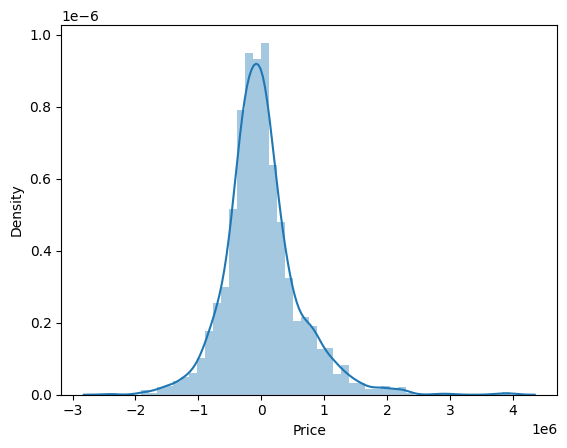

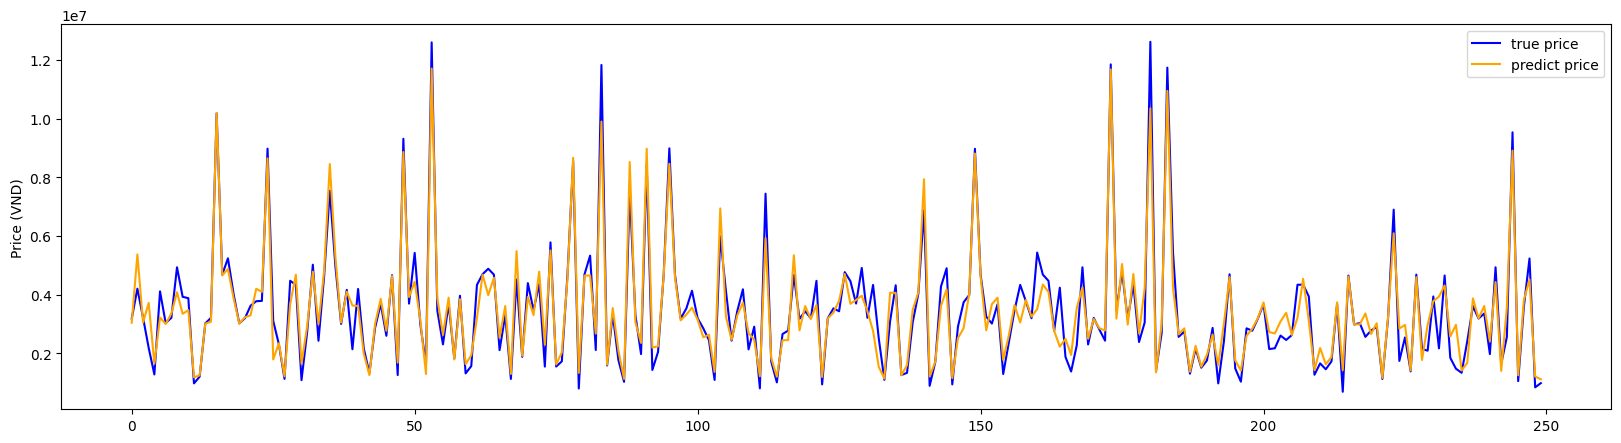

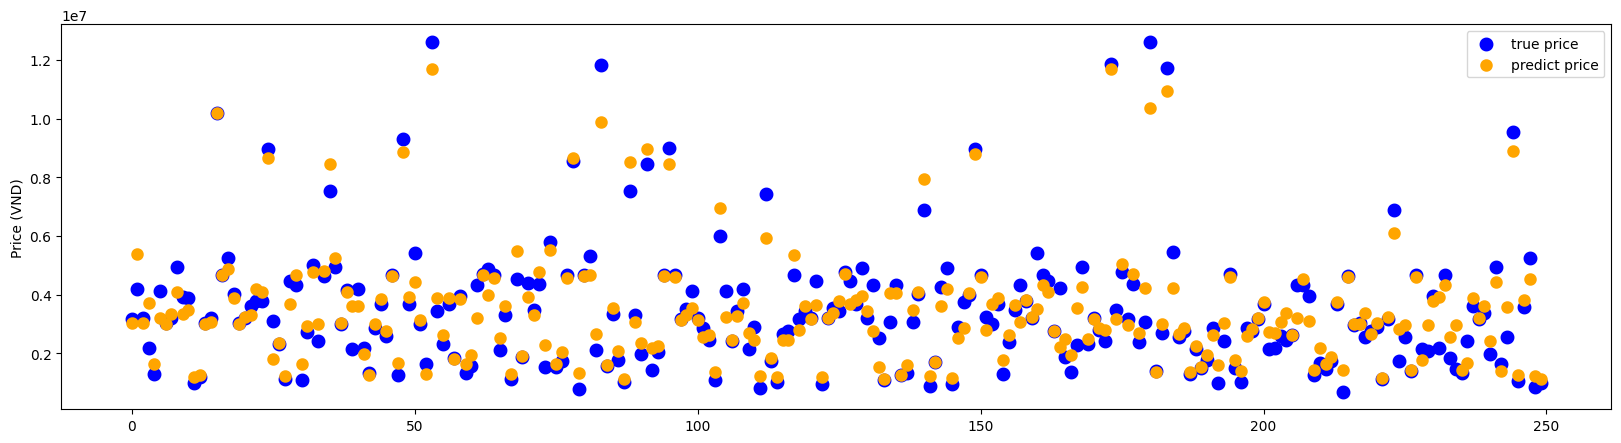

In [17]:
lgb_hyper = lgb.LGBMRegressor(**best_hyperparams_lgb, random_state=42)
predictions_lgb_hyper, training_score_lgb_hyper, val_score_lgb_hyper, MAE_lgb_hyper, MSE_lgb_hyper, RMSE_lgb_hyper = predict(lgb_hyper, X_train, X_val)
plot_val(predictions_lgb_hyper)

In [18]:
lgb_default_hyper = []
lgb_default_hyper.append(['', 'Default Parameter', 'Hyper Parameter'])
lgb_default_hyper.append(['Training score', training_score_lgb, training_score_lgb_hyper])
lgb_default_hyper.append(['Val  score', val_score_lgb, val_score_lgb_hyper])
lgb_default_hyper.append(['MAE', MAE_lgb, MAE_lgb_hyper])
lgb_default_hyper.append(['MSE', MSE_lgb, MSE_lgb_hyper])
lgb_default_hyper.append(['RMSE', RMSE_lgb, RMSE_lgb_hyper])
print(tabulate(lgb_default_hyper, headers='firstrow', tablefmt='fancy_grid', numalign='right', floatfmt=".2f"))

╒════════════════╤═════════════════════╤═══════════════════╕
│                │   Default Parameter │   Hyper Parameter │
╞════════════════╪═════════════════════╪═══════════════════╡
│ Training score │                0.94 │              0.94 │
├────────────────┼─────────────────────┼───────────────────┤
│ Val  score     │                0.93 │              0.92 │
├────────────────┼─────────────────────┼───────────────────┤
│ MAE            │           409131.63 │         420977.77 │
├────────────────┼─────────────────────┼───────────────────┤
│ MSE            │     346888188029.77 │   356874917630.18 │
├────────────────┼─────────────────────┼───────────────────┤
│ RMSE           │           588972.15 │         597390.09 │
╘════════════════╧═════════════════════╧═══════════════════╛


#### 2. Với các đặc trưng đã chọn

Model: LGBMRegressor(learning_rate=0.01, min_child_samples=4, min_split_gain=0,
              n_estimators=500, num_leaves=41, random_state=42)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 234
[LightGBM] [Info] Number of data points in the train set: 8946, number of used features: 7
[LightGBM] [Info] Start training from score 3431747.048960
╒══════════════════╤═════════════════╕
│ Metrics          │          Values │
╞══════════════════╪═════════════════╡
│ Training score   │            0.88 │
├──────────────────┼─────────────────┤
│ Validation score │            0.86 │
├──────────────────┼─────────────────┤
│ MAE              │       588013.33 │
├──────────────────┼─────────────────┤
│ MSE              │ 632316800063.39 │
├──────────────────┼─────────────────┤
│ RMSE            

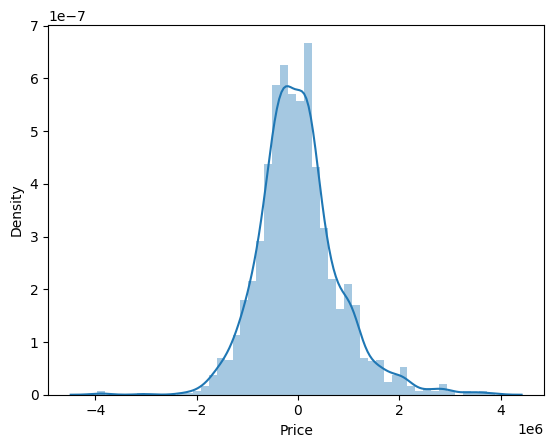

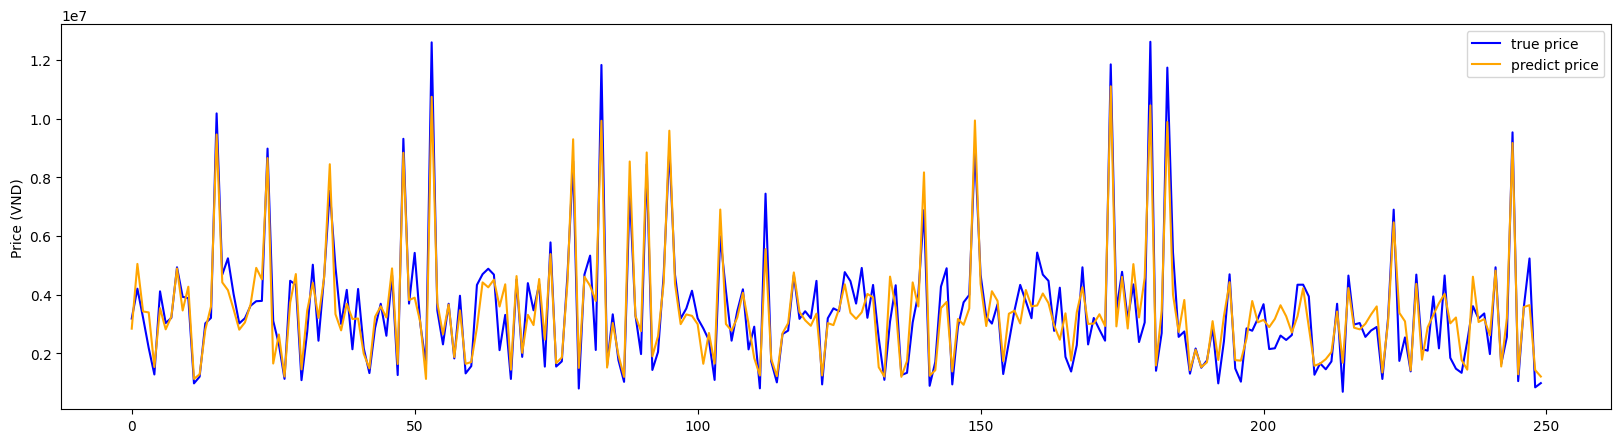

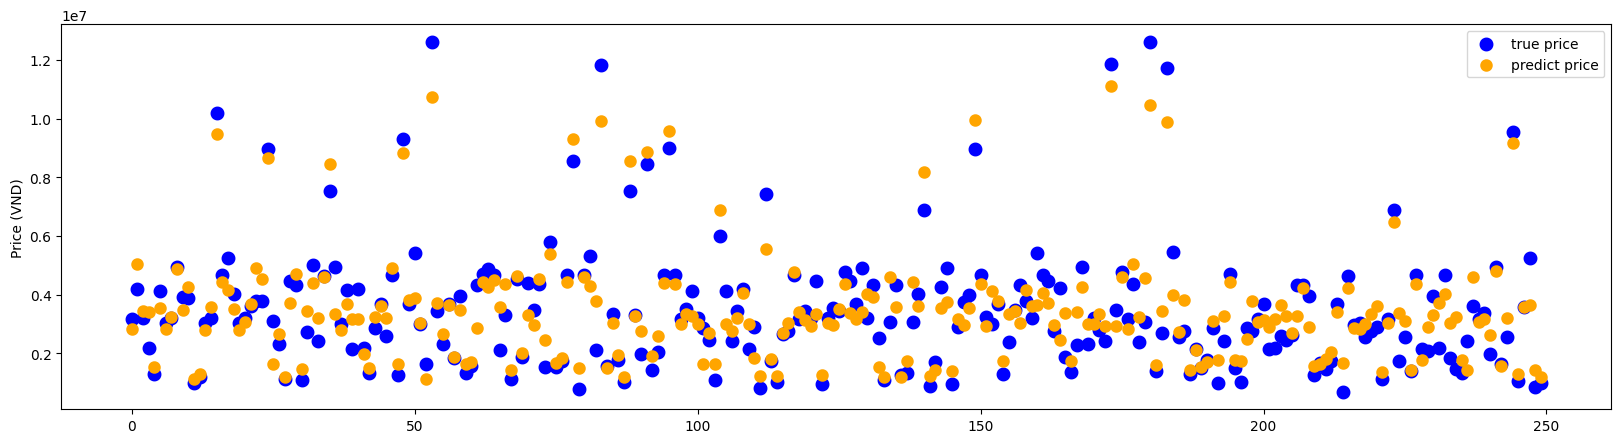

In [19]:
lgb_hyper = lgb.LGBMRegressor(**best_hyperparams_lgb, random_state=42)
predictions_lgb_fs_hyper, training_score_lgb_fs_hyper, val_score_lgb_fs_hyper, MAE_lgb_fs_hyper, MSE_lgb_fs_hyper, RMSE_lgb_fs_hyper = predict(lgb_hyper, X_train_lgb, X_val_lgb)
plot_val(predictions_lgb_fs_hyper)

In [20]:
lgb_default_hyper = []
lgb_default_hyper.append(['', 'Default Parameter', 'Hyper Parameter'])
lgb_default_hyper.append(['Training score', training_score_lgb_fs, training_score_lgb_fs_hyper])
lgb_default_hyper.append(['Val  score', val_score_lgb_fs, val_score_lgb_fs_hyper])
lgb_default_hyper.append(['MAE', MAE_lgb_fs, MAE_lgb_fs_hyper])
lgb_default_hyper.append(['MSE', MSE_lgb_fs, MSE_lgb_fs_hyper])
lgb_default_hyper.append(['RMSE', RMSE_lgb_fs, RMSE_lgb_fs_hyper])
print(tabulate(lgb_default_hyper, headers='firstrow', tablefmt='fancy_grid', numalign='right', floatfmt=".2f"))

╒════════════════╤═════════════════════╤═══════════════════╕
│                │   Default Parameter │   Hyper Parameter │
╞════════════════╪═════════════════════╪═══════════════════╡
│ Training score │                0.89 │              0.88 │
├────────────────┼─────────────────────┼───────────────────┤
│ Val  score     │                0.87 │              0.86 │
├────────────────┼─────────────────────┼───────────────────┤
│ MAE            │           567611.56 │         588013.33 │
├────────────────┼─────────────────────┼───────────────────┤
│ MSE            │     602402286800.55 │   632316800063.39 │
├────────────────┼─────────────────────┼───────────────────┤
│ RMSE           │           776145.79 │         795183.50 │
╘════════════════╧═════════════════════╧═══════════════════╛


## 7. Đánh giá mô hình trên tập Test


## LightGBM mặc định với toàn bộ đặc trưng (Test set)
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8946, number of used features: 52
[LightGBM] [Info] Start training from score 3431747.048960

## LightGBM mặc định với 7 đặc trưng quan trọng nhất (Test set)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 234
[LightGBM] [Info] Number of data points in the train set: 8946, number of used features: 7
[LightGBM] [Info] Start training from sc

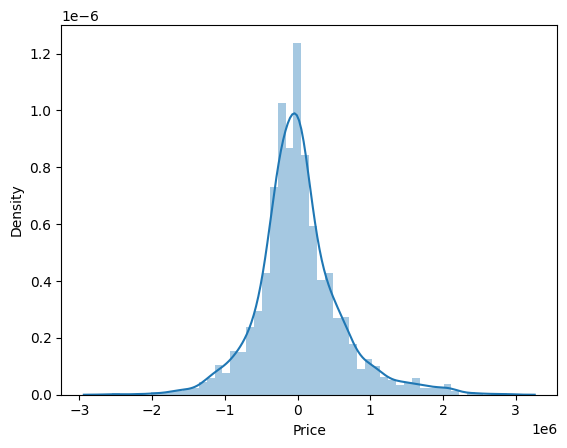

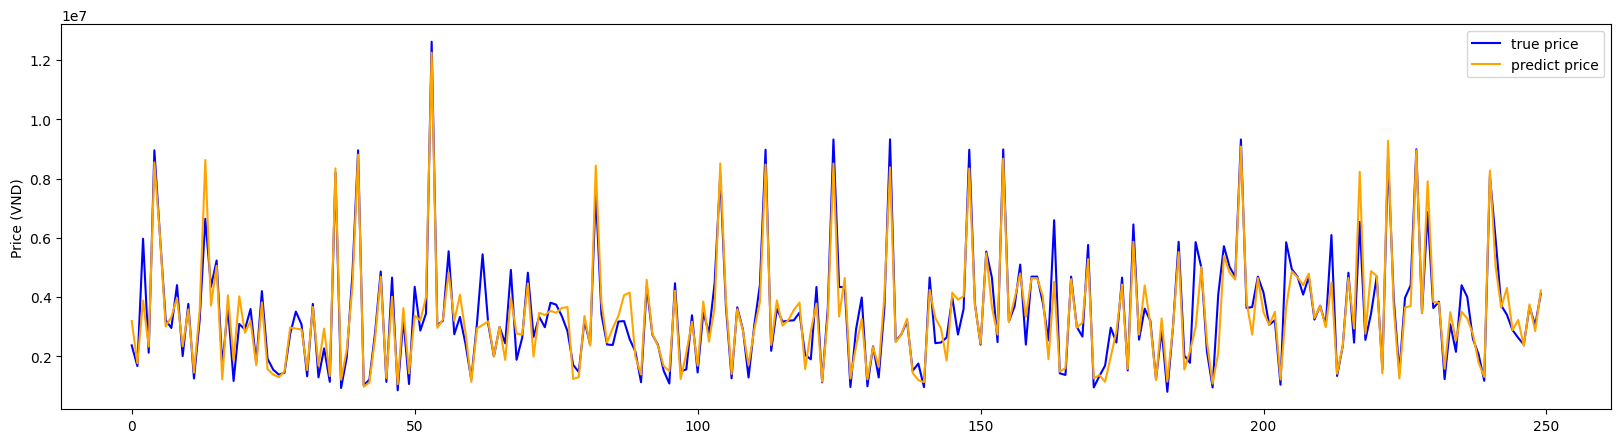

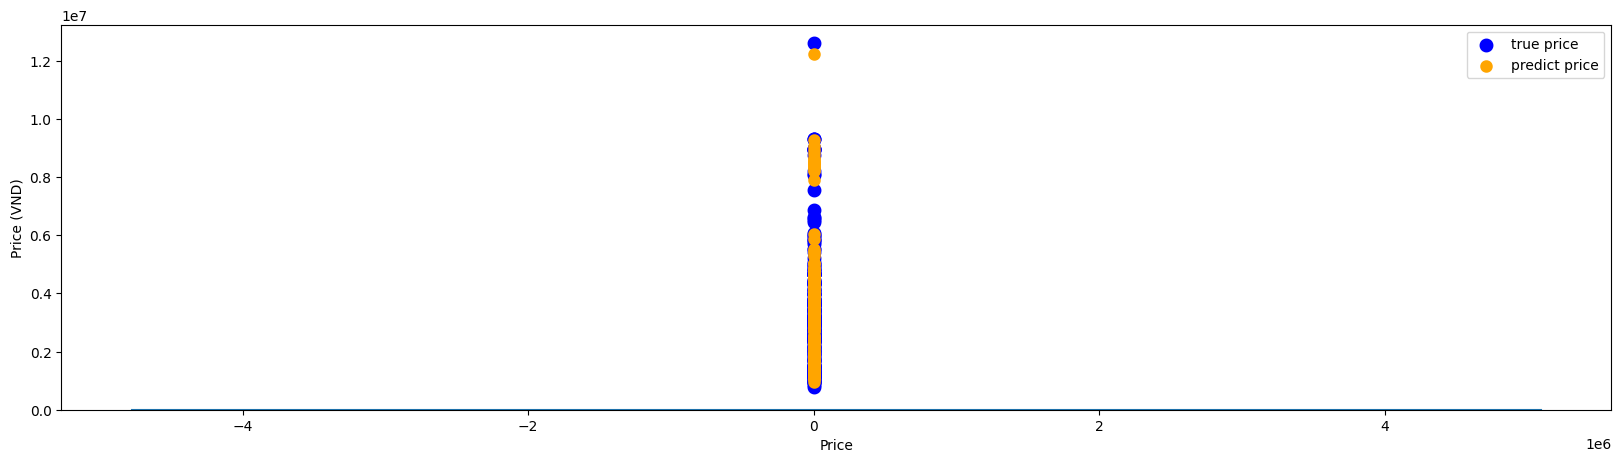

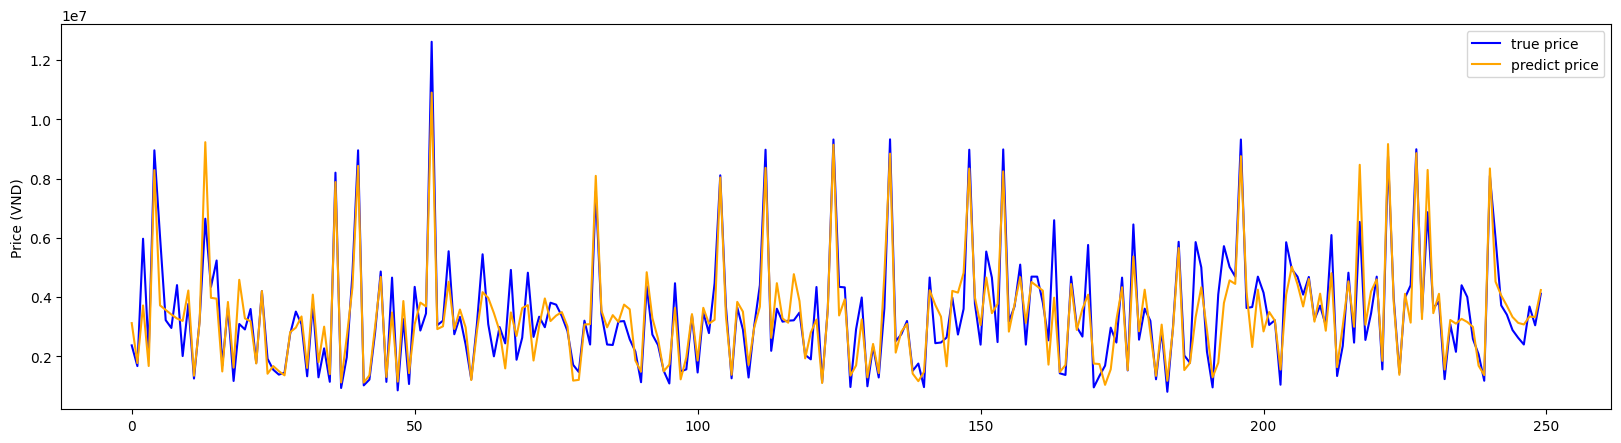

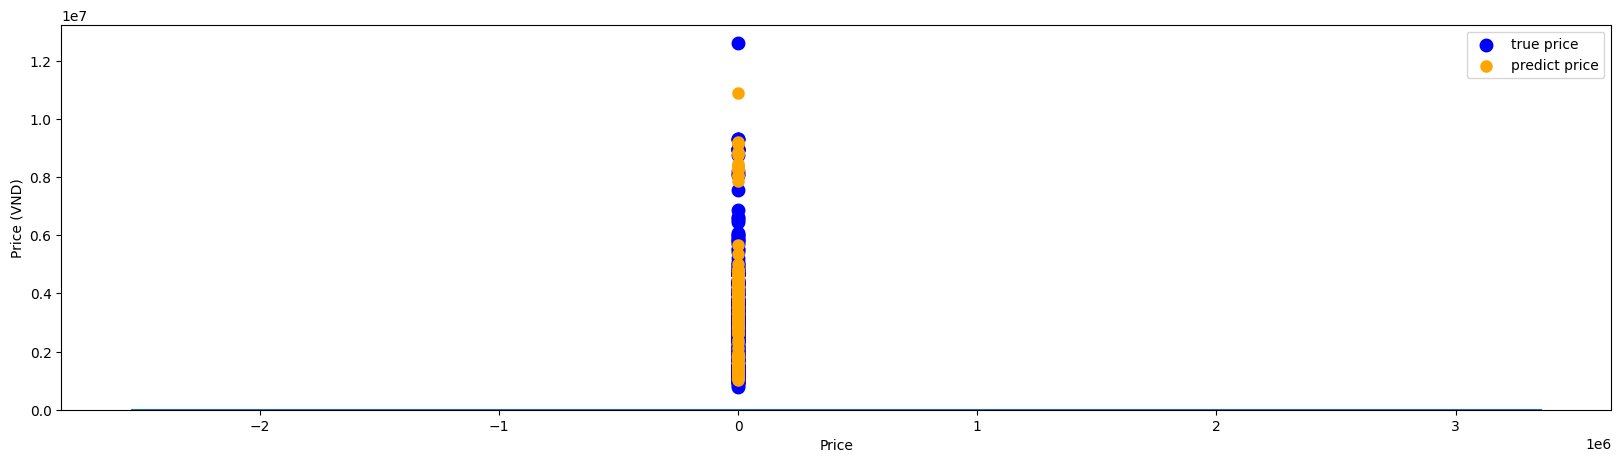

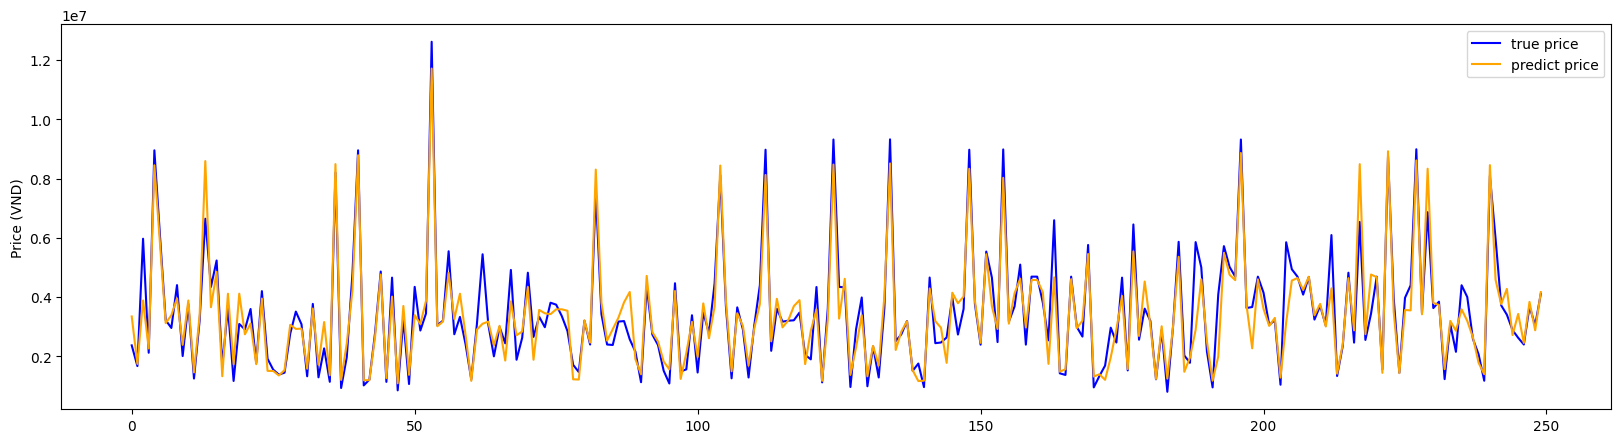

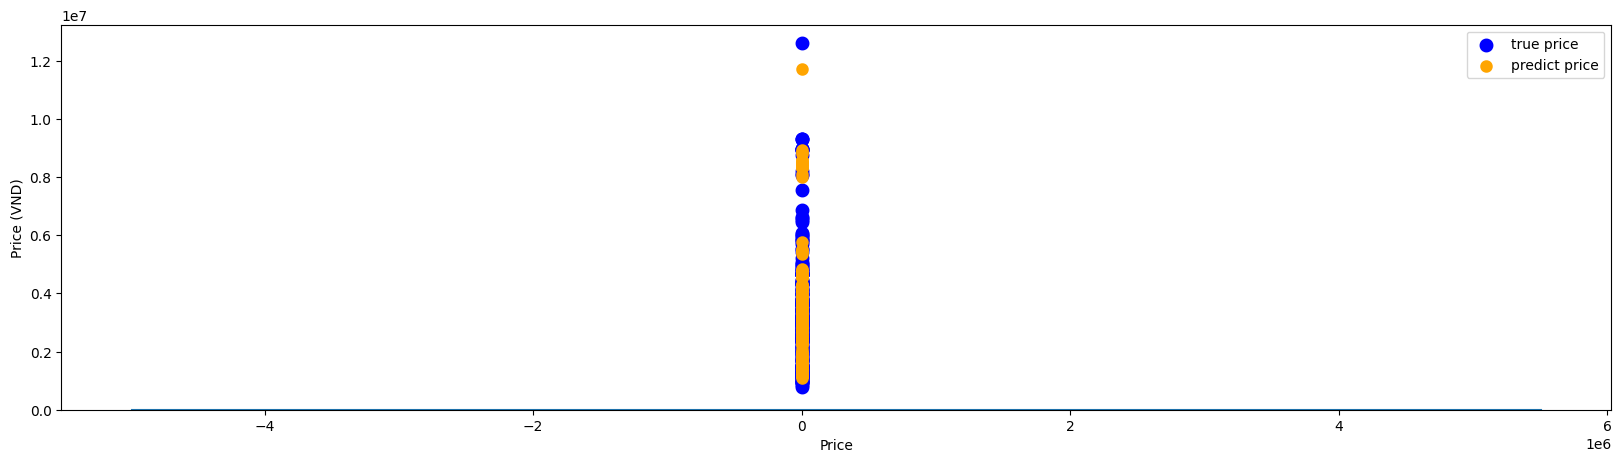

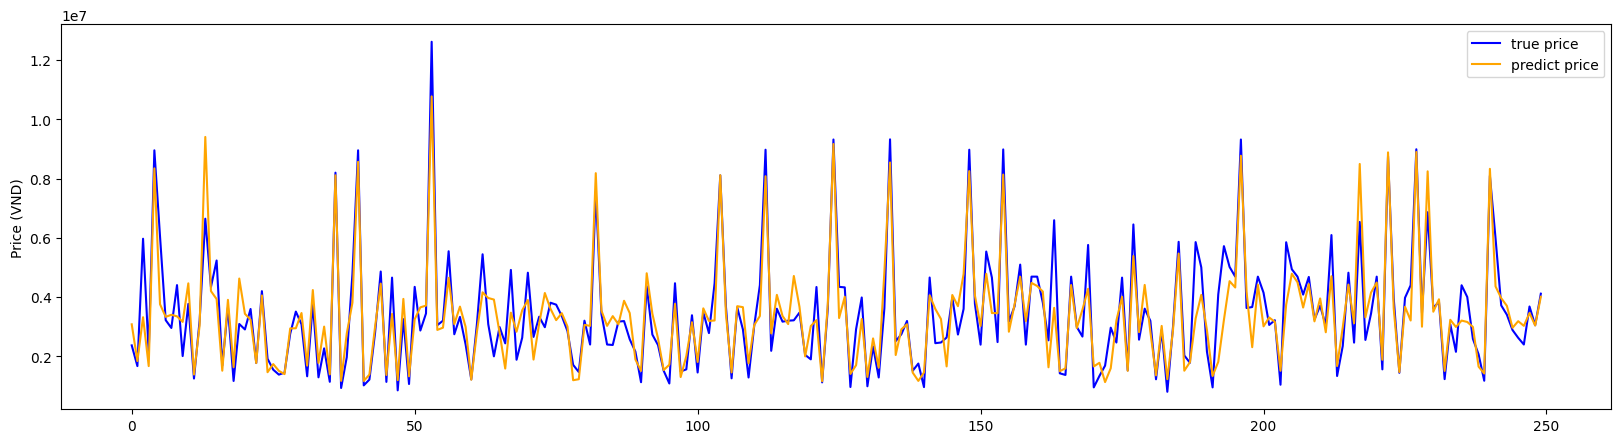

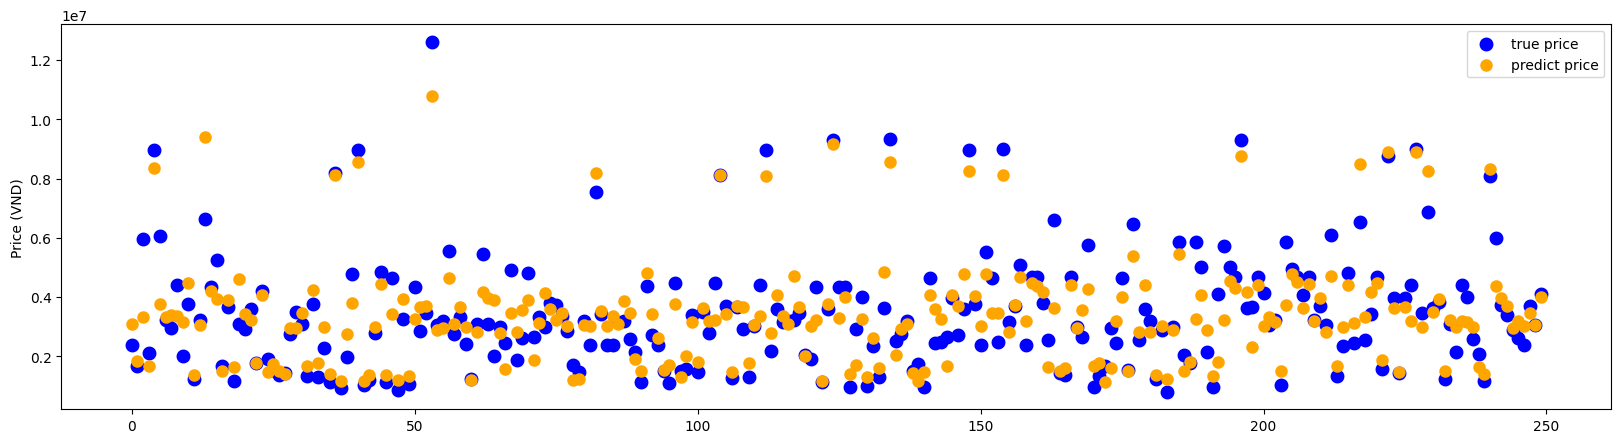

In [ ]:
# Đánh giá mô hình trên tập Test

# 1. LightGBM với tham số mặc định và toàn bộ đặc trưng
print("\n## LightGBM mặc định với toàn bộ đặc trưng (Test set)")
lightgbm_default = lgb.LGBMRegressor(random_state=42)
lightgbm_default.fit(X_train, y_train)
default_all_test_preds = lightgbm_default.predict(X_test)

test_r2_default_all = r2_score(y_test, default_all_test_preds)
test_mae_default_all = mean_absolute_error(y_test, default_all_test_preds)
test_mse_default_all = mean_squared_error(y_test, default_all_test_preds)
test_rmse_default_all = np.sqrt(test_mse_default_all)

# 2. LightGBM với tham số mặc định và 7 đặc trưng quan trọng nhất
print("\n## LightGBM mặc định với 7 đặc trưng quan trọng nhất (Test set)")
X_test_lgb = X_test[importance_df['Feature'].tolist()]
lightgbm_default_fs = lgb.LGBMRegressor(random_state=42)
lightgbm_default_fs.fit(X_train_lgb, y_train)
default_fs_test_preds = lightgbm_default_fs.predict(X_test_lgb)

test_r2_default_fs = r2_score(y_test, default_fs_test_preds)
test_mae_default_fs = mean_absolute_error(y_test, default_fs_test_preds)
test_mse_default_fs = mean_squared_error(y_test, default_fs_test_preds)
test_rmse_default_fs = np.sqrt(test_mse_default_fs)

# 3. LightGBM với tham số tối ưu và toàn bộ đặc trưng
print("\n## LightGBM tối ưu với toàn bộ đặc trưng (Test set)")
lightgbm_tuned = lgb.LGBMRegressor(**best_hyperparams_lgb, random_state=42)
lightgbm_tuned.fit(X_train, y_train) 
tuned_all_test_preds = lightgbm_tuned.predict(X_test)

test_r2_tuned_all = r2_score(y_test, tuned_all_test_preds)
test_mae_tuned_all = mean_absolute_error(y_test, tuned_all_test_preds)
test_mse_tuned_all = mean_squared_error(y_test, tuned_all_test_preds)
test_rmse_tuned_all = np.sqrt(test_mse_tuned_all)

# 4. LightGBM với tham số tối ưu và 7 đặc trưng quan trọng nhất
print("\n## LightGBM tối ưu với 7 đặc trưng quan trọng nhất (Test set)")
lightgbm_tuned_fs = lgb.LGBMRegressor(**best_hyperparams_lgb, random_state=42)
lightgbm_tuned_fs.fit(X_train_lgb, y_train)
tuned_fs_test_preds = lightgbm_tuned_fs.predict(X_test_lgb)

test_r2_tuned_fs = r2_score(y_test, tuned_fs_test_preds)
test_mae_tuned_fs = mean_absolute_error(y_test, tuned_fs_test_preds)
test_mse_tuned_fs = mean_squared_error(y_test, tuned_fs_test_preds)
test_rmse_tuned_fs = np.sqrt(test_mse_tuned_fs)

# Bảng tổng hợp kết quả
results_table = []
results_table.append(['Toàn bộ đặc trưng', '', '7 đặc trưng quan trọng nhất', ''])
results_table.append(['', 'Mặc định', 'Tinh chỉnh', 'Mặc định', 'Tinh chỉnh'])
results_table.append(['R²', test_r2_default_all, test_r2_tuned_all, test_r2_default_fs, test_r2_tuned_fs])
results_table.append(['MAE', test_mae_default_all, test_mae_tuned_all, test_mae_default_fs, test_mae_tuned_fs])
results_table.append(['MSE', test_mse_default_all, test_mse_tuned_all, test_mse_default_fs, test_mse_tuned_fs])
results_table.append(['RMSE', test_rmse_default_all, test_rmse_tuned_all, test_rmse_default_fs, test_rmse_tuned_fs])

print("\n## Bảng tổng hợp kết quả đánh giá trên tập Test")
print(tabulate(results_table, headers='firstrow', tablefmt='fancy_grid', numalign='right', floatfmt=".4f"))

# Vẽ biểu đồ kết quả cho các mô hình
print("\n## Biểu đồ dự đoán của LightGBM mặc định với toàn bộ đặc trưng")
plot(default_all_test_preds)

print("\n## Biểu đồ dự đoán của LightGBM mặc định với 7 đặc trưng quan trọng nhất")
plot(default_fs_test_preds)

print("\n## Biểu đồ dự đoán của LightGBM tối ưu với toàn bộ đặc trưng")
plot(tuned_all_test_preds)

print("\n## Biểu đồ dự đoán của LightGBM tối ưu với 7 đặc trưng quan trọng nhất")
plot(tuned_fs_test_preds)

# Lưu mô hình tốt nhất (dựa trên R² hoặc RMSE)
import pickle
best_model_metrics = [
    (test_r2_default_all, "lightgbm_default_all", lightgbm_default),
    (test_r2_default_fs, "lightgbm_default_fs", lightgbm_default_fs),
    (test_r2_tuned_all, "lightgbm_tuned_all", lightgbm_tuned),
    (test_r2_tuned_fs, "lightgbm_tuned_fs", lightgbm_tuned_fs)
]

best_model_info = max(best_model_metrics, key=lambda x: x[0])
best_model_name = best_model_info[1]
best_model = best_model_info[2]

with open(f'../models/{best_model_name}.pkl', 'wb') as f:
    pickle.dump(best_model, f)
print(f"\nĐã lưu mô hình tốt nhất ({best_model_name}, R²={best_model_info[0]:.4f}) vào '../models/{best_model_name}.pkl'")